In [54]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import data_visualization as dv
import dill
import scipy 
from scipy.stats import norm
from scipy import stats
import sys
import importlib
import pingouin as pg
import pandas as pd
import analysis_utilities as au
from itertools import combinations
from IPython.display import display
from statsmodels.multivariate.manova import MANOVA

'''
Using function now instead of writing things over and over again 
'''

'\nUsing function now instead of writing things over and over again \n'

In [55]:
sys.path.insert(0,r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement')
import plot_functions as pf
import read_data_functions as rdf
import Statistics_Object
from initializer import InitialThangs
from Subject_Object_v3 import perc
%load_ext autoreload
%autoreload 2
'''
'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\n'

## Initial Thangs

In [56]:
experiment = 'Exp2'
it = InitialThangs(experiment)

In [57]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()
os.getcwd()

'D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_Exp2'

## Pickle Objects

In [58]:
group = rdf.generate_subject_object_v3(experiment,)

## Set Save to True or False

In [59]:
save = False

## Create DataFrame for Pingouin

In [60]:
wins                 = perc(group.score_metrics.score_metric('wins')).flatten().tolist()
indecisions          = perc(group.score_metrics.score_metric('indecisions')).flatten().tolist()
incorrects           = perc(group.score_metrics.score_metric('incorrects')).flatten().tolist()
correct_decisions    = perc(group.movement_metrics.correct_initial_decisions).flatten().tolist()
median_leave_time    = np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2).flatten().tolist()
q1_median_leave_time = np.nanquantile(group.movement_metrics.movement_onset_times('task'),0.25,axis=2).flatten().tolist()
q3_median_leave_time = np.nanquantile(group.movement_metrics.movement_onset_times('task'),0.75,axis=2).flatten().tolist()
leave_time_sd        = np.nanstd(group.movement_metrics.movement_onset_times('task'),axis=2).flatten().tolist()
gamble_leave_time    = np.nanmedian(group.react_guess_movement_metrics.react_guess_movement_onset_times('react'),axis=2).flatten().tolist()
median_movement_time        = np.nanmedian(group.movement_metrics.movement_times('task'),axis=2).flatten().tolist()
reaction_decisions   = perc(group.react_guess_score_metrics.total_reaction_guess('react')) .flatten().tolist()
gamble_decisions   = perc(group.react_guess_score_metrics.total_reaction_guess('guess')) .flatten().tolist()
wins_when_both_decide = group.score_metrics.wins_when_both_reach(perc=True).flatten().tolist()
subject_number = np.repeat(np.arange(1,it.num_subjects+1,1,dtype=int),it.num_blocks).tolist()
condition = np.tile(np.arange(1,it.num_blocks+1,1,dtype=int),it.num_subjects).tolist()
# alt_condition = np.tile(['1000 (50)','1000 (150)','1100 (50)','1100 (150)', '1200 (50)', '1200 (150)'],it.num_subjects).tolist()
if experiment == 'Exp1':
    factor1 = np.tile(['1000','1000','1100','1100','1200','1200'],it.num_subjects) 
    factor2 = np.tile(['50','150'],it.num_subjects*3)    
    points = np.full_like(wins,0)
else:
    factor1 = np.tile(['0 Inc','-1 Inc','0 Inc','-1 Inc'],it.num_subjects) 
    factor2 = np.tile(['0 Ind','0 Ind','-1 Ind','-1 Ind'],it.num_subjects) 
    points = group.score_metrics.exp2_points_scored.flatten().tolist()
    decision_time_difference_punish_incorrects = np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[0] - np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[1] 
    decision_time_difference_punish_indecisions = np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[0] - np.nanmedian(group.movement_metrics.movement_onset_times('task'),axis=2)[2]  
df_metrics = pd.DataFrame(
    np.array([median_leave_time,median_movement_time,wins,indecisions,incorrects,correct_decisions,wins_when_both_decide,
                                    gamble_leave_time,leave_time_sd,q1_median_leave_time,q3_median_leave_time,
                                    reaction_decisions,gamble_decisions,points]).T,
    columns=['Median_Leave_Time','Median_Movement_Time','Wins','Indecisions','Incorrects','Correct_Decisions','Wins_When_Both_Decide',
             'Median_Gamble_Leave_Time','SD_Leave_Time','Q1_Leave_Time','Q3_Leave_Time','Reaction_Decisions','Gamble_Decisions','Points']
)
df_conditions = pd.DataFrame(
    np.array([subject_number,condition,factor1,factor2]).T,
    columns = ['Subject','Condition','Factor_1','Factor_2']
)
# df_metrics.astype('float64')

# df = df.astype({'Subject':'int32','Condition':'int32','Condition Mean':'int32','Condition SD':'int32'})
# dill.dump(df,open(save_path+'\\metrics_df_all_subjects.pkl','wb')) 
df = pd.concat([df_conditions,df_metrics],axis=1)
# assert ~df.isnull().any(axis=1).any(),('NaN Values found in dataframe')
display(df.iloc[6:12])

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,Subject,Condition,Factor_1,Factor_2,Median_Leave_Time,Median_Movement_Time,Wins,Indecisions,Incorrects,Correct_Decisions,Wins_When_Both_Decide,Median_Gamble_Leave_Time,SD_Leave_Time,Q1_Leave_Time,Q3_Leave_Time,Reaction_Decisions,Gamble_Decisions,Points
6,2,3,0 Inc,-1 Ind,1101.0,246.0,38.75,28.75,32.50,55.00,54.385965,1349.0,283.157728,817.25,1298.25,30.00,70.00,43.0
7,2,4,-1 Inc,-1 Ind,1226.0,238.0,30.00,37.50,32.50,55.00,48.000000,1350.5,167.895290,1075.00,1317.00,38.75,61.25,44.0
8,3,1,0 Inc,0 Ind,1317.0,169.0,48.75,35.00,16.25,71.25,75.000000,1346.0,69.298737,1274.00,1347.25,53.75,46.25,49.0
9,3,2,-1 Inc,0 Ind,1330.0,153.0,53.75,43.75,2.50,83.75,95.555556,1346.0,60.634638,1297.25,1375.00,81.25,18.75,61.0
10,3,3,0 Inc,-1 Ind,1224.5,182.0,52.50,10.00,37.50,56.25,58.333333,1339.0,117.114244,1124.75,1297.00,27.50,72.50,34.0
11,3,4,-1 Inc,-1 Ind,1362.0,116.0,67.50,31.25,1.25,92.50,98.181818,1362.0,45.318234,1327.00,1383.50,92.50,7.50,42.0


## Initialize bootstrap

In [61]:
so = Statistics_Object.Statistics(df, experiment = experiment, num_subjects = it.num_subjects, num_blocks=it.num_blocks,num_trials=it.num_trials,trial_block_titles=it.trial_block_titles,
                                  xlab=it.xlabel, f1_xticklabels=it.f1_collapse_xticklabs,f2_xticklabels=it.f2_collapse_xticklabs,f1_xlabel=it.f1_xlabel,f2_xlabel=it.f2_xlabel,
                                  M = 1e6)

In [62]:
_,b = so.run_statistics('Median_Leave_Time',change_m=1e2)
_,b = so.run_statistics('Median_Leave_Time',change_m=1e2,test='median')

Non-significant interaction, collapsing across conditions...
Non-significant interaction, collapsing across conditions...


## Median Leave Times

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,93906.315104,1,23,93906.315104,16.784232,0.000442,0.000442,0.078188,1.0
1,Factor_2,37071.690104,1,23,37071.690104,12.883761,0.001550,0.001550,0.032400,1.0
2,Factor_1 * Factor_2,2076.690104,1,23,2076.690104,1.239047,0.277154,0.277154,0.001872,1.0


Collapsing, changed select conditions to be All


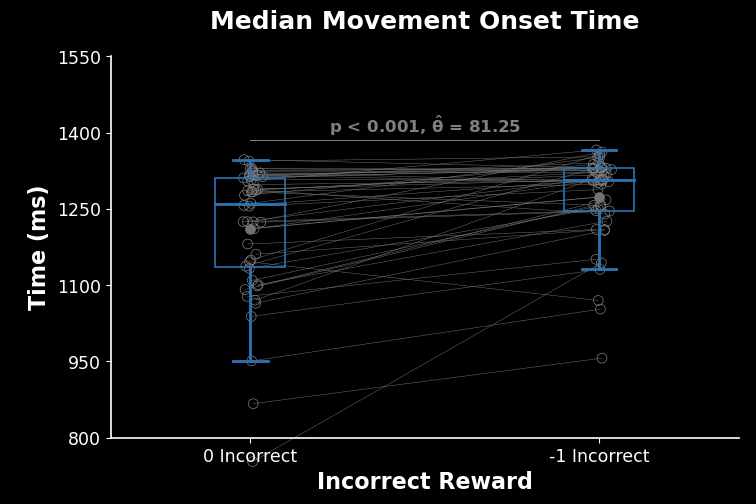

Collapsing, changed select conditions to be All


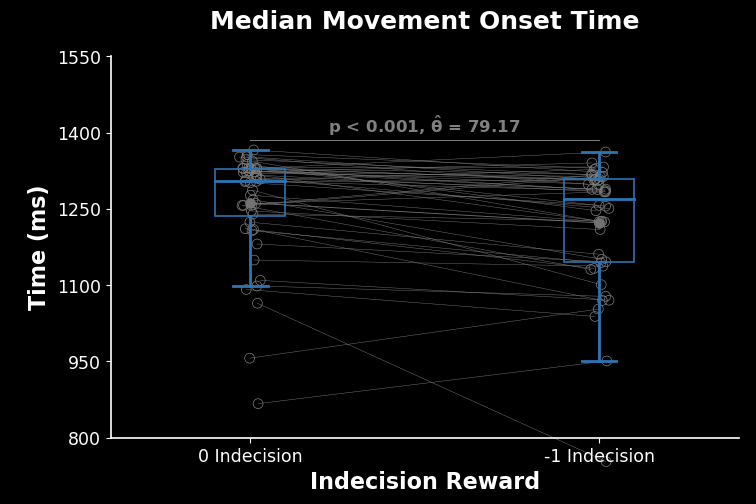

In [63]:
median_leave_time_anova,median_leave_time_statistics = so.run_statistics('Median_Leave_Time')
display(median_leave_time_anova)
so.plot(median_leave_time_statistics,'Median_Leave_Time',title='Median Movement Onset Time',
                    ylab='Time (ms)',title_pad = 20,ylocs=np.arange(800,1650,150),lims=True)

## Median Movement Times

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,1763.877604,1,23,1763.877604,5.641124,0.026264,0.026264,0.006918,1.0
1,Factor_2,164.065104,1,23,164.065104,1.236200,0.277692,0.277692,0.000648,1.0
2,Factor_1 * Factor_2,1.377604,1,23,1.377604,0.010095,0.920839,0.920839,0.000005,1.0


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


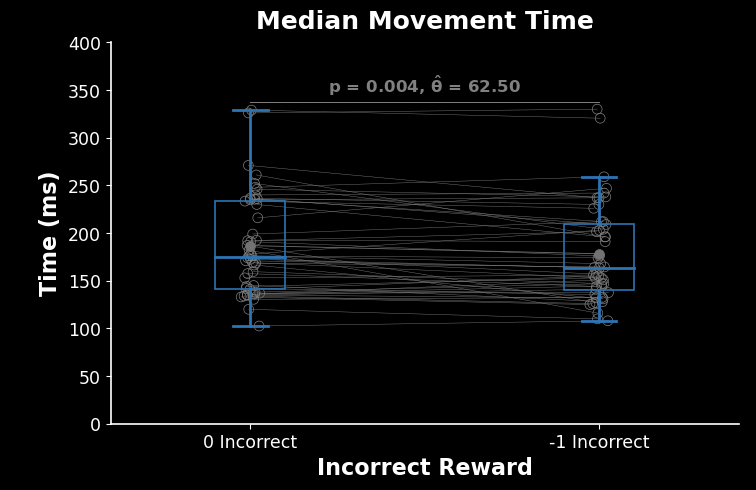

Collapsing, changed select conditions to be All


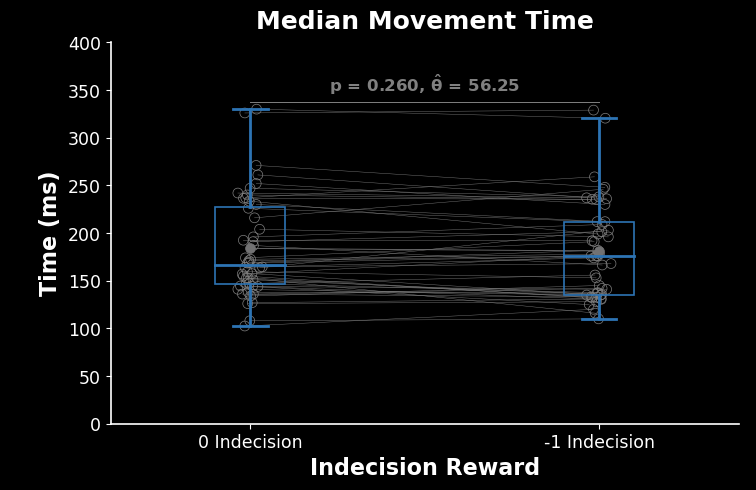

In [64]:
median_movement_time_anova,median_movement_time_statistics = so.run_statistics('Median_Movement_Time')
display(median_movement_time_anova)
so.plot(median_movement_time_statistics,'Median_Movement_Time',title='Median Movement Time',
                    ylab='Time (ms)',ylocs=np.arange(0,450,50),lims=True)

## SD Leave Times

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,5094.493890,1,23,5094.493890,6.486379,0.018025,0.018025,0.015257,1.0
1,Factor_2,2.925356,1,23,2.925356,0.002475,0.960754,0.960754,0.000009,1.0
2,Factor_1 * Factor_2,3428.820244,1,23,3428.820244,2.624392,0.118864,0.118864,0.010320,1.0


!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


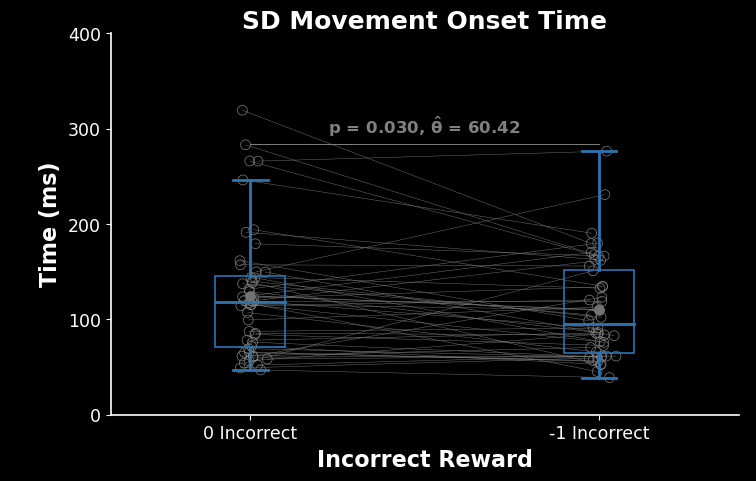

Collapsing, changed select conditions to be All


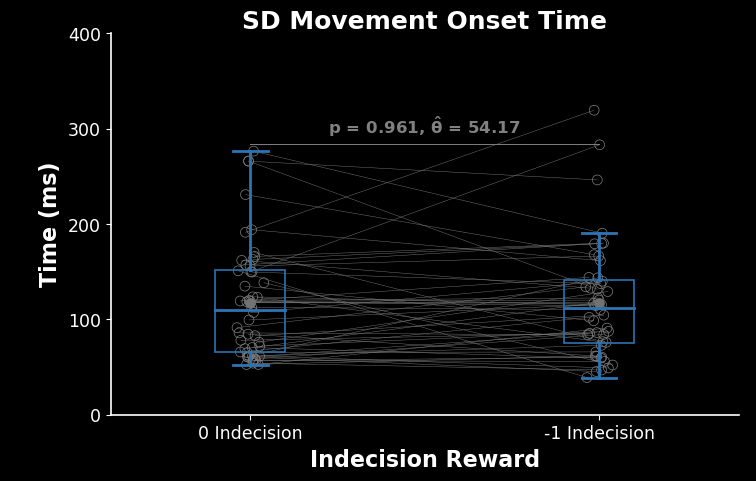

In [65]:
sd_leave_time_anova,sd_leave_time_statistics = so.run_statistics('SD_Leave_Time')
display(sd_leave_time_anova)
so.plot(sd_leave_time_statistics,'SD_Leave_Time',title='SD Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(0,450,100),title_pad = 0,lims=True,cut_pvals=False)

## First Quartile Leave Time

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,137070.377604,1,23,137070.377604,17.151106,0.000396,0.000396,0.059396,1.0
1,Factor_2,39833.127604,1,23,39833.127604,6.022958,0.022113,0.022113,0.018020,1.0
2,Factor_1 * Factor_2,4676.041667,1,23,4676.041667,0.971256,0.334622,0.334622,0.002150,1.0


Collapsing, changed select conditions to be All


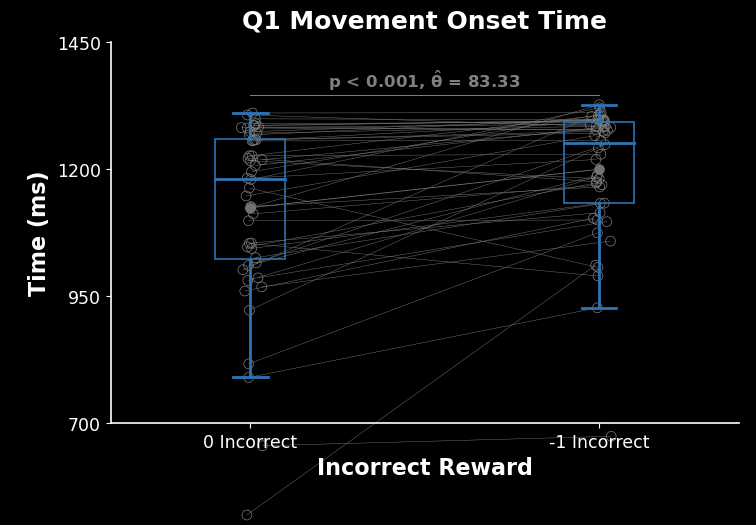

Collapsing, changed select conditions to be All


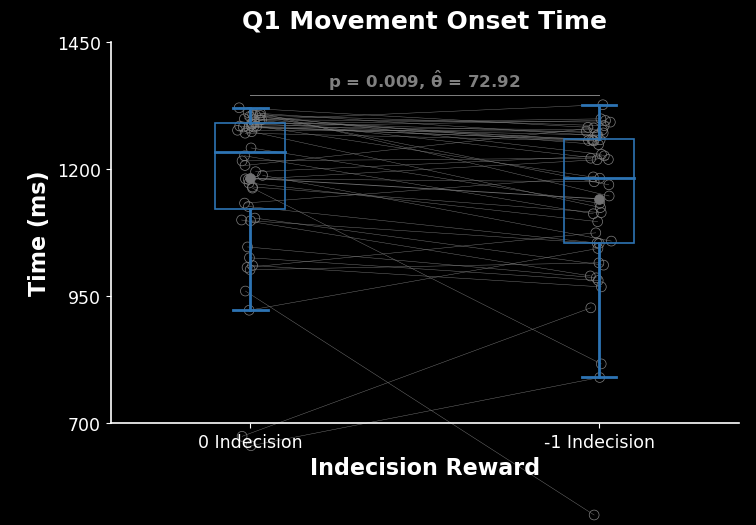

In [66]:
q1_leave_time_anova,q1_leave_time_statistics = so.run_statistics('Q1_Leave_Time')
display(q1_leave_time_anova)
so.plot(q1_leave_time_statistics,'Q1_Leave_Time',title='Q1 Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(700,1600,250),lims=True)

## Third Quartile Leave Time

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,52558.740234,1,23,52558.740234,11.734478,0.002311,0.002311,0.074750,1.0
1,Factor_2,24153.828776,1,23,24153.828776,15.307558,0.000699,0.000699,0.035798,1.0
2,Factor_1 * Factor_2,296.630859,1,23,296.630859,0.355400,0.556894,0.556894,0.000456,1.0


Collapsing, changed select conditions to be All


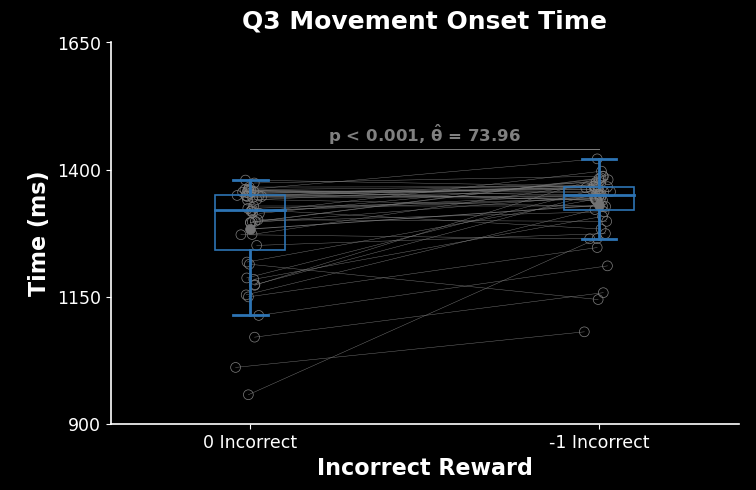

Collapsing, changed select conditions to be All


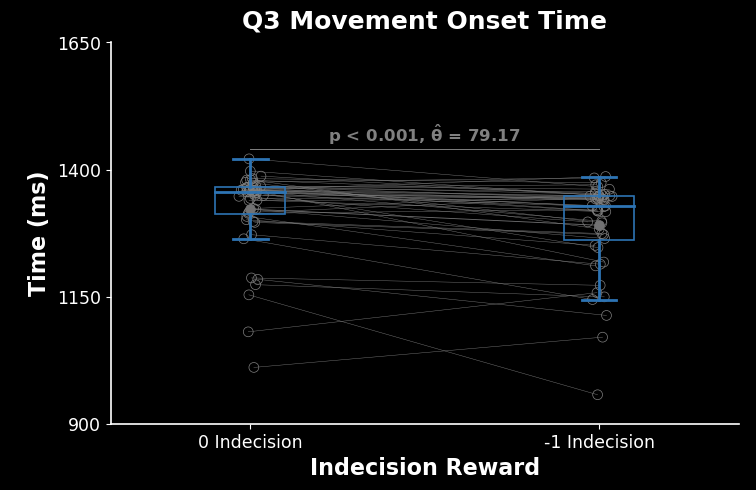

In [67]:
q3_leave_time_anova,q3_leave_time_statistics = so.run_statistics('Q3_Leave_Time')
display(q3_leave_time_anova)
so.plot(q3_leave_time_statistics,'Q3_Leave_Time',title='Q3 Movement Onset Time',
                    ylab='Time (ms)',ylocs=np.arange(900,1700,250),lims=True)

## Correct Decisions (Doesn't matter if indecision)

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,961.083984,1,23,961.083984,13.901704,0.001101,0.001101,0.055086,1.0
1,Factor_2,724.625651,1,23,724.625651,9.332097,0.005616,0.005616,0.042104,1.0
2,Factor_1 * Factor_2,27.360026,1,23,27.360026,0.537531,0.470865,0.470865,0.001657,1.0


Collapsing, changed select conditions to be All


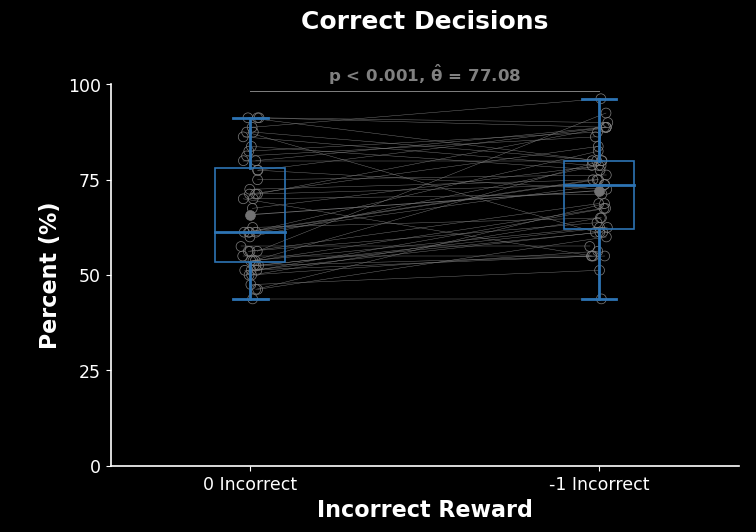

Collapsing, changed select conditions to be All


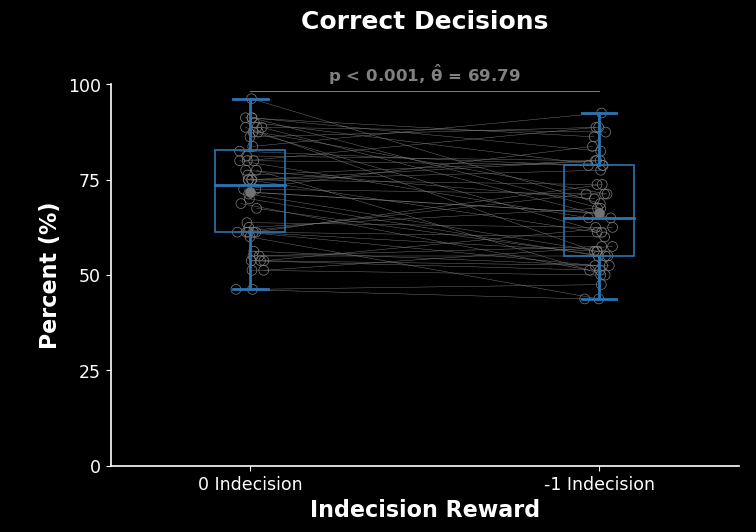

In [68]:
corrects_anova,corrects_statistics = so.run_statistics('Correct_Decisions')
display(corrects_anova)
so.plot(corrects_statistics,'Correct_Decisions',title='Correct Decisions',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=40,h=1)

## Wins When Both Decide

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,2621.337058,1,23,2621.337058,28.593252,0.000020,0.000020,0.082390,1.0
1,Factor_2,1327.322454,1,23,1327.322454,11.777962,0.002275,0.002275,0.043487,1.0
2,Factor_1 * Factor_2,0.973580,1,23,0.973580,0.016459,0.899033,0.899033,0.000033,1.0


Collapsing, changed select conditions to be All


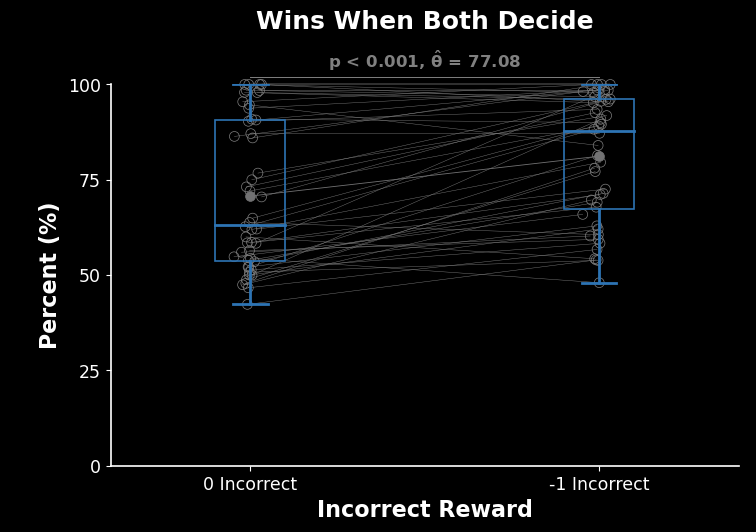

Collapsing, changed select conditions to be All


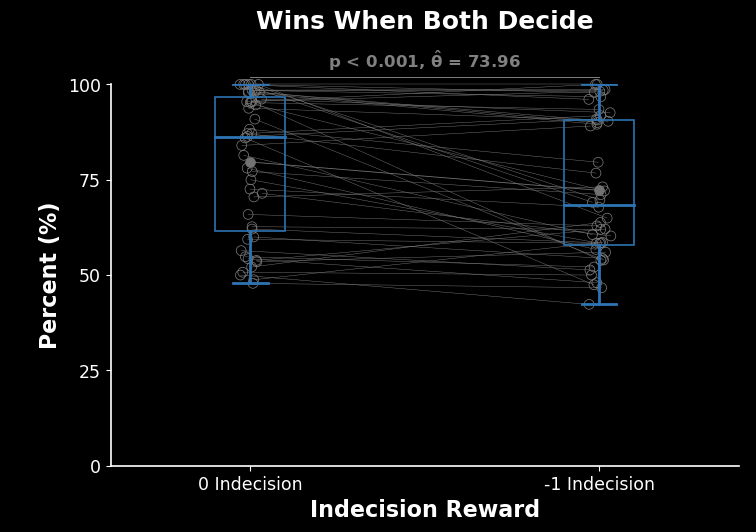

In [69]:
wins_when_both_decide_anova,wins_when_both_decide_statistics = so.run_statistics('Wins_When_Both_Decide')
display(wins_when_both_decide_anova)
so.plot(wins_when_both_decide_statistics,'Wins_When_Both_Decide',title='Wins When Both Decide',
                    ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=40,h=1)

# Points Scored

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,1107.041667,1,23,1107.041667,2.619150,0.119214,0.119214,0.027663,1.0
1,Factor_2,1107.041667,1,23,1107.041667,3.806850,0.063328,0.063328,0.027663,1.0
2,Factor_1 * Factor_2,24.000000,1,23,24.000000,0.121279,0.730819,0.730819,0.000616,1.0


!! Factor 1 is not significant !!
!! Factor 2 is not significant !!
Collapsing, changed select conditions to be All


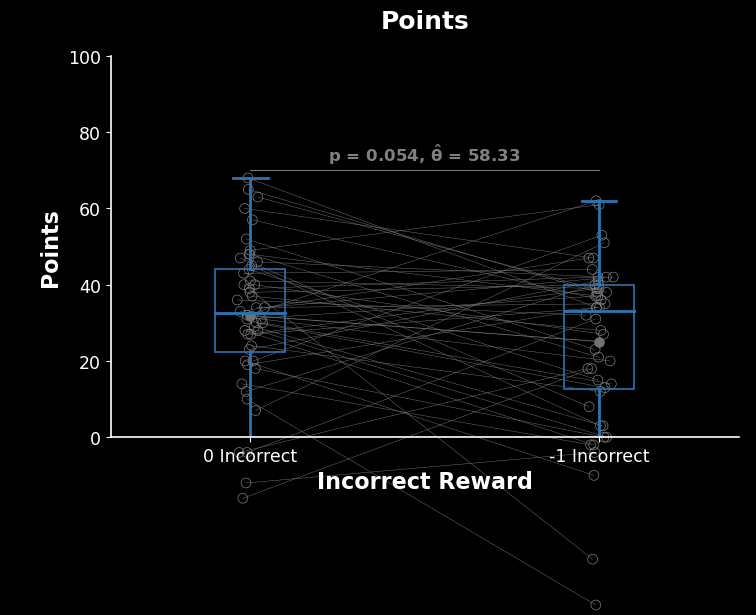

Collapsing, changed select conditions to be All


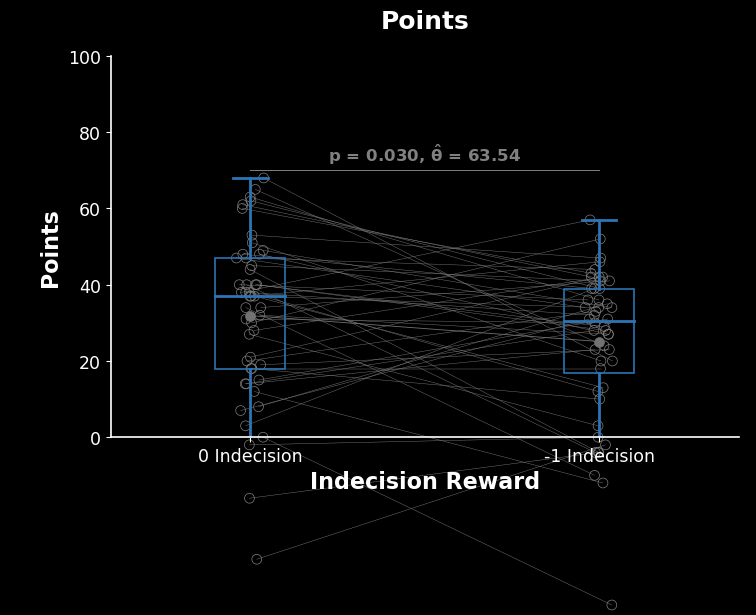

In [70]:
if experiment == 'Exp2':
    points_anova,points_statistics = so.run_statistics('Points')
    display(points_anova)
    so.plot(points_statistics,'Points',title='Points',
                    ylab='Points',ylocs=np.arange(0,101,20),lims=True,title_pad=20,h=1,cut_pvals=False)

## Wins

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,64.599609,1,23,64.599609,1.196250,0.285396,0.285396,0.003406,1.0
1,Factor_2,684.000651,1,23,684.000651,14.373504,0.000943,0.000943,0.034924,1.0
2,Factor_1 * Factor_2,101.578776,1,23,101.578776,2.237580,0.148288,0.148288,0.005345,1.0


!! Factor 1 is not significant !!
Collapsing, changed select conditions to be All


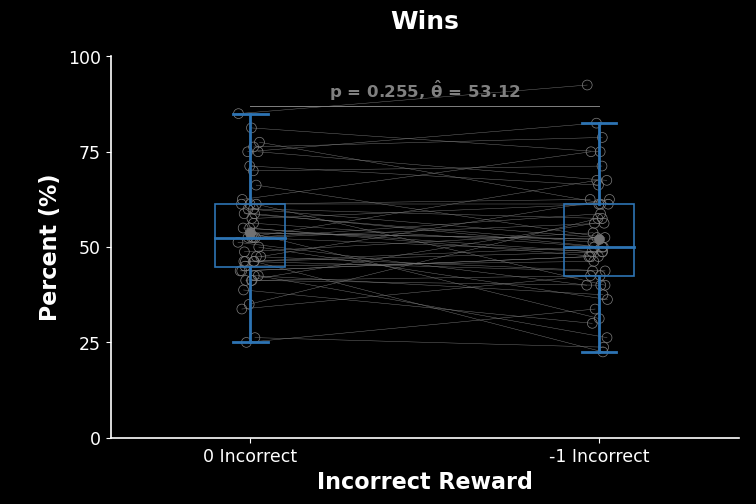

Collapsing, changed select conditions to be All


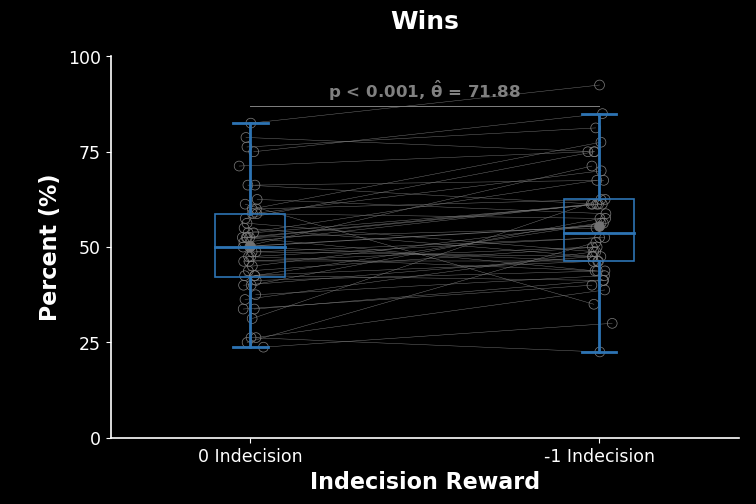

In [71]:
wins_anova,wins_statistics = so.run_statistics('Wins')
display(wins_anova)
so.plot(wins_statistics,'Wins',title='Wins',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=20,h=1,cut_pvals=False)

## Incorrects

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,3223.063151,1,23,3223.063151,35.928712,0.000004,0.000004,0.141776,1.0
1,Factor_2,1594.547526,1,23,1594.547526,20.684693,0.000144,0.000144,0.075553,1.0
2,Factor_1 * Factor_2,3.662109,1,23,3.662109,0.068679,0.795603,0.795603,0.000188,1.0


Collapsing, changed select conditions to be All


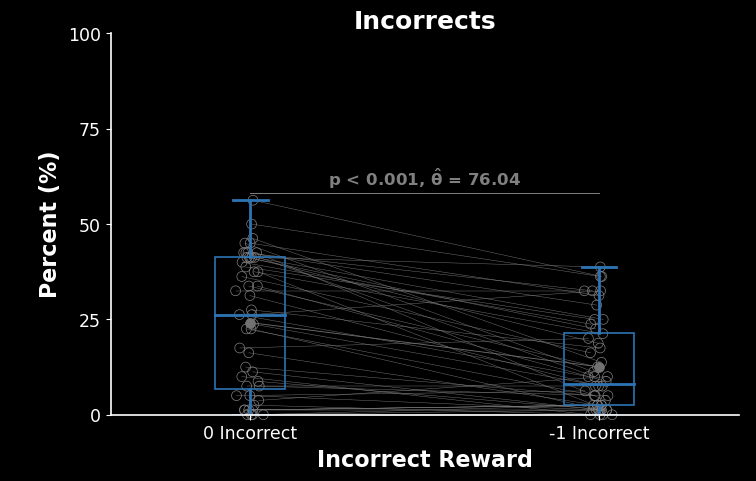

Collapsing, changed select conditions to be All


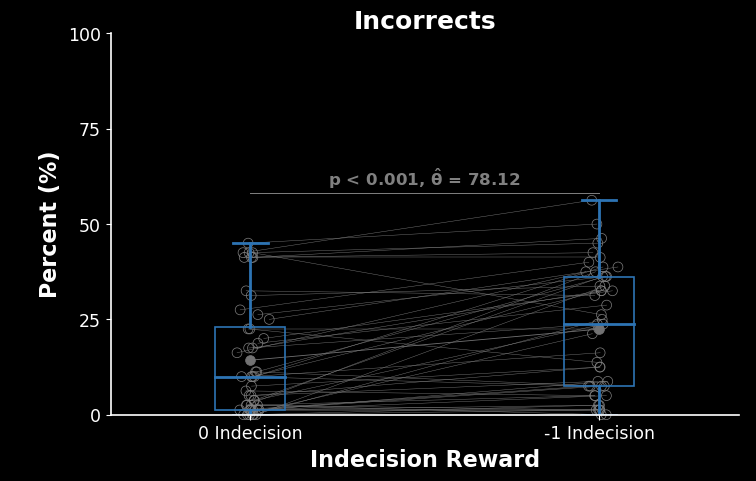

In [72]:
incorrects_anova,incorrects_statistics = so.run_statistics('Incorrects',test='median')
display(incorrects_anova)
so.plot(incorrects_statistics,'Incorrects',title='Incorrects',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=0,h=0.5,
                cut_pvals = False)

## Indecisions

Anova

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,4200.260417,1,23,4200.260417,27.883870,2.332336e-05,2.332336e-05,0.194678,1.0
1,Factor_2,4367.252604,1,23,4367.252604,46.874161,5.560409e-07,5.560409e-07,0.200864,1.0
2,Factor_1 * Factor_2,66.666667,1,23,66.666667,0.747493,3.961991e-01,3.961991e-01,0.003822,1.0


Collapsing, changed select conditions to be All


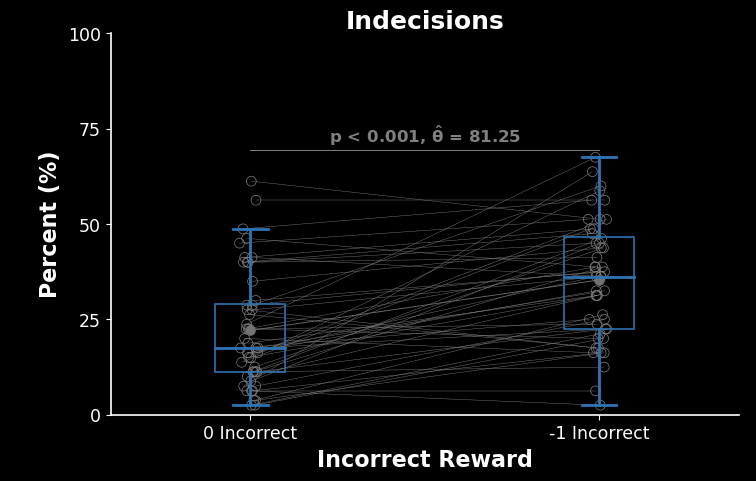

Collapsing, changed select conditions to be All


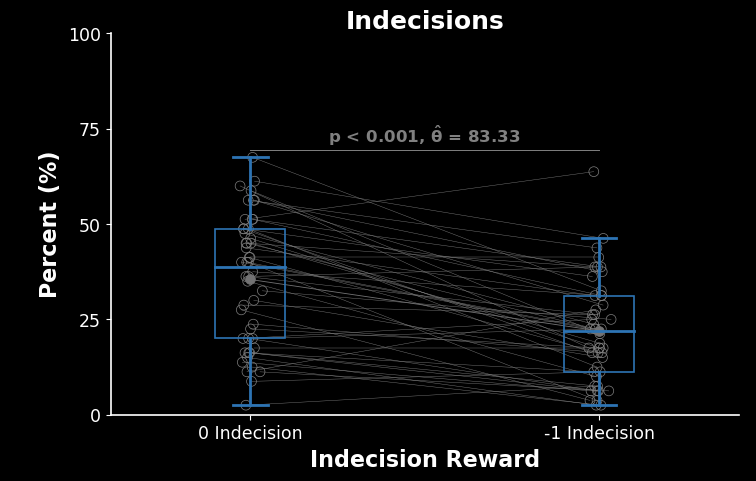

In [73]:
if experiment == 'Exp1':
    alternative = 'less'
else:
    alternative = 'two-sided'
    
indecisions_anova,indecisions_statistics = so.run_statistics('Indecisions',alternative = 'two-sided')
display(indecisions_anova)
so.plot(indecisions_statistics,'Indecisions',title='Indecisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=0,h=0.5,
                cut_pvals = False)

# MANOVA Wins, Indecisions, Incorrects

In [74]:
df.head()

,Subject,Condition,Factor_1,Factor_2,Median_Leave_Time,Median_Movement_Time,Wins,Indecisions,Incorrects,Correct_Decisions,Wins_When_Both_Decide,Median_Gamble_Leave_Time,SD_Leave_Time,Q1_Leave_Time,Q3_Leave_Time,Reaction_Decisions,Gamble_Decisions,Points
0,1,1,0 Inc,0 Ind,1344.0,134.0,60.00,40.00,0.00,91.25,100.000000,1348.5,61.514993,1310.75,1373.50,95.00,5.00,48.0
1,1,2,-1 Inc,0 Ind,1352.5,126.0,57.50,41.25,1.25,90.00,97.872340,1357.0,123.192329,1311.50,1387.00,93.75,6.25,21.0
2,1,3,0 Inc,-1 Ind,1225.0,145.0,62.50,3.75,33.75,67.50,64.935065,1343.5,143.627711,1147.50,1295.25,22.50,77.50,39.0
3,1,4,-1 Inc,-1 Ind,1308.5,128.0,75.00,16.25,8.75,78.75,89.552239,1324.0,75.874064,1266.25,1348.25,70.00,30.00,42.0
4,2,1,0 Inc,0 Ind,1287.0,216.0,26.25,56.25,17.50,70.00,60.000000,1354.0,149.903932,1163.00,1357.00,52.50,47.50,60.0


In [81]:
maov = MANOVA.from_formula('Wins + Indecisions + \
                            Incorrects ~ Factor_1 + Factor_2', data=df)
print(maov.mv_test())

                                 Multivariate linear model
                                                                                           
-------------------------------------------------------------------------------------------
       Intercept                Value         Num DF  Den DF         F Value         Pr > F
-------------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 3.0000 91.0000 -22768198116150868.0000 1.0000
         Pillai's trace                1.0000 3.0000 91.0000 -22768198116150868.0000 1.0000
 Hotelling-Lawley trace -750599937895083.6250 3.0000 91.0000 -22768198116150872.0000 1.0000
    Roy's greatest root -750599937895083.6250 3.0000 91.0000 -22768198116150868.0000 1.0000
-------------------------------------------------------------------------------------------
                                                                                           
---------------------

# Reaction Decisions

In [76]:
reactions_anova,reactions_statistics = so.run_statistics('Reaction_Decisions',alternative = 'two-sided')
display(reactions_anova)
so.plot(reactions_statistics,'Reaction_Decisions',title='Reaction Decisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=80,h=0.5,
                cut_pvals = True)

KeyError: 'Reaction Decisions'

Non-significant interaction, collapsing across conditions...


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor 1,5381.266276,1,23,5381.266276,19.102294,0.000224,0.000224,0.071550,1.0
1,Factor 2,4085.302734,1,23,4085.302734,17.384487,0.000369,0.000369,0.055271,1.0
2,Factor 1 * Factor 2,19.938151,1,23,19.938151,0.108060,0.745338,0.745338,0.000285,1.0


Collapsing, changed select conditions to be All


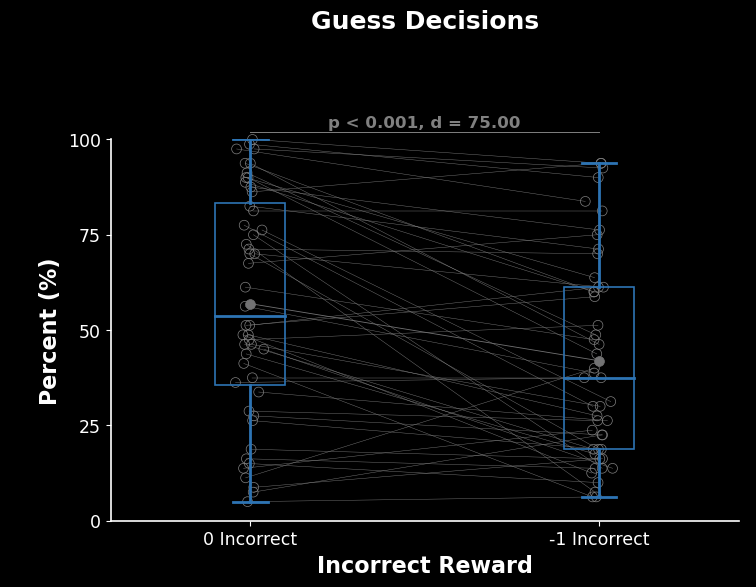

Collapsing, changed select conditions to be All


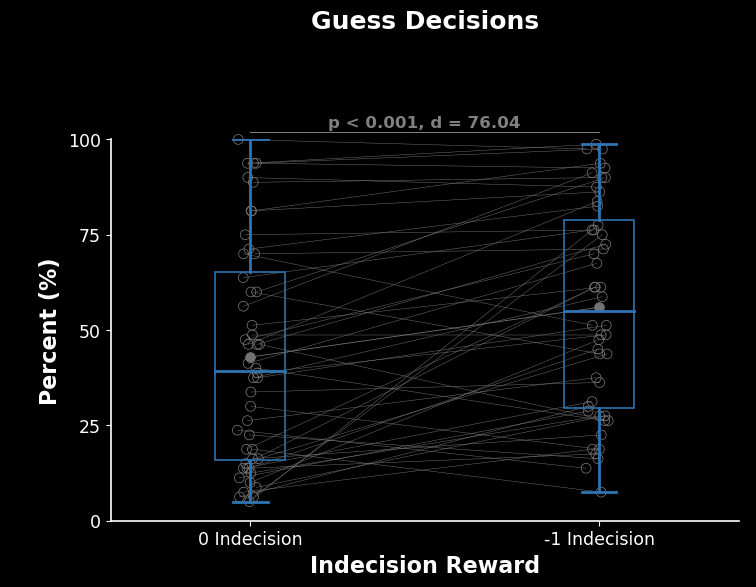

In [ ]:
gambles_anova,gambles_statistics = so.run_statistics('Gamble_Decisions',alternative = 'two-sided')
display(gambles_anova)
so.plot(gambles_statistics,'Gamble_Decisions',title='Guess Decisions',
                ylab='Percent (%)',ylocs=np.arange(0,125,25),lims=True,title_pad=80,h=0.5,
                cut_pvals = True)